<a href="https://colab.research.google.com/github/Buy-me-some-str/practice/blob/main/transfer_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision import models, transforms, datasets

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225])
    ]) 

In [3]:
train_data = datasets.CIFAR10(root="data",
                              train=True,
                              download=True,
                              transform=data_transform,
                              target_transform=None)
test_data = datasets.CIFAR10(root="data",
                             train=False,
                             download=True,
                             transform=data_transform,
                             target_transform=None)

100%|██████████| 170498071/170498071 [00:04<00:00, 40998745.49it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
classes = train_data.classes
targets = train_data.targets

Text(0.5, 1.0, 'ship')

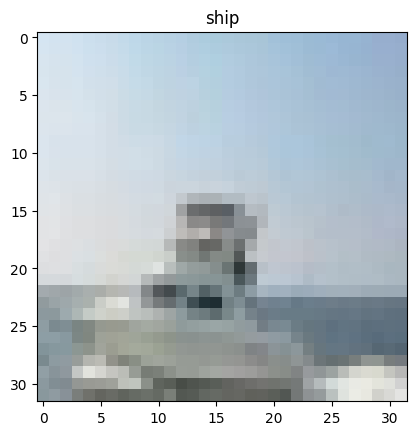

In [5]:
plt.imshow(train_data.data[100], label=targets[100])
plt.title(classes[targets[100]])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

## Функциональное обучение

In [41]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch, (X,y) in tqdm(enumerate(dataloader)):
        X = X.to(device)
        y = y.to(device)
        y_preds = model.forward(X)
        loss = loss_fn(y_preds, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_preds=y_preds.argmax(dim=1))
        optim.zero_grad()
        loss.backward()
        optim.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.2f} | Train acc: {train_acc:.2f}%")

In [9]:
def accuracy_fn(y_preds: torch.Tensor,
                y_true: torch.Tensor)->torch.float:
                correct = torch.eq(y_preds, y_true).sum().item()
                acc = (correct / len(y_preds))*100
                return acc

In [36]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            y_preds = model.forward(X)
            loss = loss_fn(y_preds, y)
            test_loss += loss
            test_acc += accuracy_fn(y_true=y,
                                    y_preds=y_preds.argmax(dim=1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}%")

In [43]:
def model_eval(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    model.to(device)
    loss = 0
    acc = 0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            y_preds = model.forward(X)
            loss += loss_fn(y_preds, y)
            acc += accuracy_fn(y_true=y,
                               y_preds=y_preds.argmax(dim=1))
        loss /= len(dataloader)
        acc /= len(dataloader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

## AlexNet

In [47]:
AlexNet = models.alexnet(pretrained=True)
AlexNet.to(device)
AlexNet.classifier[6] = torch.nn.Linear(4096, 10)
optim = torch.optim.Adam(AlexNet.classifier[6].parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
AlexNet_without_train_results = model_eval(model=AlexNet,
                                           dataloader=test_dataloader,
                                           loss_fn=loss_fn,
                                           accuracy_fn=accuracy_fn,
                                           device=device)

  0%|          | 0/313 [00:00<?, ?it/s]

In [50]:
EPOCHS = 2
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch} --------------------")
    train_step(model=AlexNet,
            dataloader=train_dataloader,
            optim=optim,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
    test_step(model=AlexNet,
              dataloader=test_dataloader,
              accuracy_fn=accuracy_fn,
              loss_fn=loss_fn,
              device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 --------------------


0it [00:00, ?it/s]

Train loss: 0.77 | Train acc: 74.14%
Test loss: 0.59 | Test acc: 79.52%
Epoch 1 --------------------


0it [00:00, ?it/s]

Train loss: 0.69 | Train acc: 77.45%
Test loss: 0.55 | Test acc: 81.39%


In [51]:
AlexNet_with_train_results = model_eval(model=AlexNet,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

  0%|          | 0/313 [00:00<?, ?it/s]

In [52]:
AlexNet_with_train_results, AlexNet_without_train_results

({'model_name': 'AlexNet',
  'model_loss': 0.5541441440582275,
  'model_acc': 81.38977635782747},
 {'model_name': 'AlexNet',
  'model_loss': 2.3846518993377686,
  'model_acc': 12.400159744408946})

## VGGNet

In [53]:
VGGNet = models.vgg16(pretrained=True)
VGGNet.to(device)
VGGNet.classifier[6] = torch.nn.Linear(4096, 10)
optim = torch.optim.Adam(VGGNet.classifier[6].parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 55.5MB/s]


In [54]:
VGGNet_without_train_results = model_eval(model=VGGNet,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          accuracy_fn=accuracy_fn,
                                          device=device)

  0%|          | 0/313 [00:00<?, ?it/s]

In [55]:
EPOCHS = 2
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch} --------------------")
    train_step(model=VGGNet,
               dataloader=train_dataloader,
               optim=optim,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=VGGNet,
              dataloader=test_dataloader,
              accuracy_fn=accuracy_fn,
              loss_fn=loss_fn,
              device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 --------------------


0it [00:00, ?it/s]

Train loss: 0.68 | Train acc: 76.88%
Test loss: 0.52 | Test acc: 81.95%
Epoch 1 --------------------


0it [00:00, ?it/s]

Train loss: 0.65 | Train acc: 78.64%
Test loss: 0.53 | Test acc: 81.57%


In [56]:
VGGNet_with_train_results = model_eval(model=VGGNet,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       accuracy_fn=accuracy_fn,
                                       device=device)

  0%|          | 0/313 [00:00<?, ?it/s]

## GoogleNet

In [57]:
GoogleNet = models.googlenet(pretrained=True)
GoogleNet.to(device)
GoogleNet.classifier[6] = torch.nn.Linear(4096, 10)
optim = torch.optim.Adam(GoogleNet.classifier[6].parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:02<00:00, 17.5MB/s]


In [58]:
GoogleNet_without_train_results = model_eval(model=GoogleNet,
                                             dataloader=test_dataloader,
                                             loss_fn=loss_fn,
                                             accuracy_fn=accuracy_fn,
                                             device=device)


  0%|          | 0/313 [00:00<?, ?it/s]

In [60]:
EPOCHS = 2
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch} --------------------")
    train_step(model=GoogleNet,
               dataloader=train_dataloader,
               optim=optim,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=GoogleNet,
              dataloader=test_dataloader,
              accuracy_fn=accuracy_fn,
              loss_fn=loss_fn,
              device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 --------------------


0it [00:00, ?it/s]

Train loss: 8.05 | Train acc: 0.10%
Test loss: 8.05 | Test acc: 0.06%
Epoch 1 --------------------


0it [00:00, ?it/s]

Train loss: 8.04 | Train acc: 0.15%
Test loss: 8.04 | Test acc: 0.07%


In [61]:
GoogleNet_with_train_results = model_eval(model=GoogleNet,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          accuracy_fn=accuracy_fn,
                                          device=device)

  0%|          | 0/313 [00:00<?, ?it/s]

## ResNet

In [ ]:
ResNet = models.resnet18(pretrained=True)
ResNet.to(device)
ResNet.classifier[6] = torch.nn.Linear(4096, 10)
optim = torch.optim.Adam(ResNet.classifier[6].parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
ResNet_without_train_results = model_eval(model=GoogleNet,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn,
                                          accuracy_fn=accuracy_fn,
                                          device=device)

In [ ]:
EPOCHS = 2
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch} --------------------")
    train_step(model=ResNet,
               dataloader=train_dataloader,
               optim=optim,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=ResNet,
              dataloader=test_dataloader,
              accuracy_fn=accuracy_fn,
              loss_fn=loss_fn,
              device=device)

In [ ]:
ResNet_with_train_results = model_eval(model=GoogleNet,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       accuracy_fn=accuracy_fn,
                                       device=device)